## Implementation based on the following paper
https://papers.nips.cc/paper_files/paper/2000/file/728f206c2a01bf572b5940d7d9a8fa4c-Paper.pdf

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build a dataset

block_size = 3 # context length: how many characters do we take to predict the next one.
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [24]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [6]:
# Embedding table
C = torch.randn((27 ,2))

In [7]:
C

tensor([[ 0.1097,  0.3826],
        [-0.3711,  0.2412],
        [ 0.3327, -0.1799],
        [ 0.8792,  0.6219],
        [-1.1146,  1.5272],
        [-2.7822, -1.6675],
        [-0.1862,  0.9141],
        [-2.2256,  1.1806],
        [ 0.1432,  0.1683],
        [ 1.0883,  0.3478],
        [-0.0763,  0.8585],
        [ 0.3538,  1.4879],
        [ 0.4308, -1.1382],
        [-0.5053, -2.1654],
        [-1.3803, -0.0195],
        [ 1.3524, -2.1868],
        [-0.0960, -0.7126],
        [ 1.4068, -1.7963],
        [-0.0477,  1.1234],
        [-0.3430, -1.1196],
        [ 1.8538,  0.9668],
        [-0.1697, -1.7828],
        [ 0.5066,  0.0654],
        [ 1.5578,  1.5257],
        [ 0.7206,  3.5816],
        [-0.1153,  0.1753],
        [-1.6474,  0.7484]])

In [8]:
C[5]

tensor([-2.7822, -1.6675])

In [9]:
C[X].shape

torch.Size([32, 3, 2])

In [10]:
X[13, 2]

tensor(1)

In [11]:
C[X][13, 2]

tensor([-0.3711,  0.2412])

In [17]:
emb = C[X]
emb.shape[0]

32

In [14]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)


In [22]:
# we need to transform embedding table 32x3x2 -> 32x6
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)
# torch.cat(torch.unbind(emb, 1), 1)
# emb.view(emb.shape[0], 6)

h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [23]:
h

tensor([[-0.2947,  0.9714, -0.7229,  ..., -0.4420,  0.8485,  0.0809],
        [ 0.9875,  1.0000,  0.9999,  ...,  0.4641,  1.0000, -0.9950],
        [-0.9792,  0.9846, -1.0000,  ..., -0.9951, -0.9725, -0.5978],
        ...,
        [ 0.8485, -0.9993, -0.8316,  ...,  0.1029, -0.5482,  0.0709],
        [-0.8688, -0.9808, -0.9890,  ..., -0.9946, -0.6533, -0.5133],
        [ 0.6027,  0.9853,  0.9491,  ..., -0.0245,  0.9973, -0.6962]])

In [25]:
h.shape

torch.Size([32, 100])

In [26]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)


In [27]:
logits = h @ W2 + b2

In [28]:
logits.shape

torch.Size([32, 27])

In [29]:
counts = logits.exp()

In [30]:
probs = counts / counts.sum(dim=1, keepdim=True)

In [31]:
probs.shape

torch.Size([32, 27])

In [32]:
probs

tensor([[1.4616e-04, 3.5440e-06, 9.3983e-07, 1.0128e-01, 2.1622e-08, 1.8031e-04,
         2.8244e-08, 5.4592e-10, 4.5916e-13, 3.0577e-11, 4.3499e-04, 1.1802e-03,
         1.2103e-01, 5.3123e-07, 1.0557e-05, 4.2715e-09, 2.5693e-01, 1.4311e-02,
         5.0093e-01, 2.6923e-03, 4.1850e-08, 1.0755e-08, 8.6709e-04, 1.0356e-07,
         1.9983e-08, 9.5897e-08, 5.3842e-09],
        [4.1992e-11, 9.4541e-01, 7.4545e-14, 1.5004e-15, 1.0551e-14, 4.4094e-06,
         5.3154e-15, 1.7207e-12, 4.4678e-08, 3.3334e-17, 6.4356e-12, 3.0236e-03,
         7.9041e-07, 4.7856e-02, 2.9663e-16, 6.9267e-12, 1.5311e-16, 1.7057e-06,
         5.1616e-17, 3.0568e-11, 5.5476e-08, 3.6987e-03, 5.4783e-12, 3.2762e-10,
         1.9207e-07, 1.1889e-11, 1.5970e-09],
        [1.3328e-10, 4.8595e-11, 4.8000e-16, 1.8653e-16, 1.4951e-07, 5.1464e-12,
         2.0278e-11, 1.6767e-15, 7.7263e-13, 6.1446e-22, 1.0959e-11, 2.5626e-02,
         5.7889e-13, 9.7407e-01, 7.3372e-12, 1.2811e-21, 8.6118e-14, 3.5969e-15,
         5.6431e-

In [46]:
C.shape

torch.Size([27, 2])

In [47]:
X.shape

torch.Size([32, 3])

In [34]:
loss = -probs[torch.arange(32), Y].log().mean()

In [35]:
loss

tensor(18.6343)

In [41]:
g = torch.Generator().manual_seed(214748364)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [42]:
sum(p.nelement() for p in parameters)

3481

In [43]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(18.3554)

In [48]:
for p in parameters:
    p.requires_grad = True

In [53]:
for _ in range(1000):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())


0.255113422870636


We are overfitting the model as we are training the model with 32 samples. We have 3481 parameters for just 32 samples. 


In [55]:
logits.max(1)

torch.return_types.max(
values=tensor([ 9.4249, 12.5891, 14.7323, 19.4710, 18.6127,  9.4249, 12.8907, 13.1190,
        17.9546, 20.1283, 23.3903, 18.3275,  9.4249, 15.5840, 24.1034, 25.5834,
         9.4249, 18.6257, 15.8134, 13.6158, 15.0183, 15.5503, 13.3028, 23.3301,
        17.6208,  9.4249, 14.3309, 12.9060, 14.3814, 17.0243, 19.9461, 23.4056],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

In [56]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [57]:
# create the dataset with all the samples
block_size = 3 # context length: how many characters do we take to predict the next one.
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [58]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [104]:
g = torch.Generator().manual_seed(214748364)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [67]:
sum(p.nelement() for p in parameters)

3481

In [105]:
for p in parameters:
    p.requires_grad = True

In [62]:
for _ in range(1000):
    # forward pass
    emb = C[X] # (228146, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
    logits = h @ W2 + b2 # (228146, 27)
    loss = F.cross_entropy(logits, Y)
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

KeyboardInterrupt: 

In [110]:
# batching the dataset for faster training

for _ in range(1000):
    # construct minibatch of size 32.
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

2.535264730453491


In [111]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5785, grad_fn=<NllLossBackward0>)

In [112]:
lre = torch.linspace(-3, 0, 1000)
lre

tensor([-3.0000, -2.9970, -2.9940, -2.9910, -2.9880, -2.9850, -2.9820, -2.9790,
        -2.9760, -2.9730, -2.9700, -2.9670, -2.9640, -2.9610, -2.9580, -2.9550,
        -2.9520, -2.9489, -2.9459, -2.9429, -2.9399, -2.9369, -2.9339, -2.9309,
        -2.9279, -2.9249, -2.9219, -2.9189, -2.9159, -2.9129, -2.9099, -2.9069,
        -2.9039, -2.9009, -2.8979, -2.8949, -2.8919, -2.8889, -2.8859, -2.8829,
        -2.8799, -2.8769, -2.8739, -2.8709, -2.8679, -2.8649, -2.8619, -2.8589,
        -2.8559, -2.8529, -2.8498, -2.8468, -2.8438, -2.8408, -2.8378, -2.8348,
        -2.8318, -2.8288, -2.8258, -2.8228, -2.8198, -2.8168, -2.8138, -2.8108,
        -2.8078, -2.8048, -2.8018, -2.7988, -2.7958, -2.7928, -2.7898, -2.7868,
        -2.7838, -2.7808, -2.7778, -2.7748, -2.7718, -2.7688, -2.7658, -2.7628,
        -2.7598, -2.7568, -2.7538, -2.7508, -2.7477, -2.7447, -2.7417, -2.7387,
        -2.7357, -2.7327, -2.7297, -2.7267, -2.7237, -2.7207, -2.7177, -2.7147,
        -2.7117, -2.7087, -2.7057, -2.70

In [117]:
lrs = 10 ** lre
len(lrs)

1000

In [120]:
# How to determine learning rate.
g = torch.Generator().manual_seed(214748364)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000) # (10 ** -3 = 0.001, 10 ** 0 = 1, lr from 0.001 - 1)
lrs = 10**lre 

lri = []
lossi = []
lrei = []
for i in range(1000):
    # construct minibatch of size 32.
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lr)
    lrei.append(lre[i])
    lossi.append(loss.item())


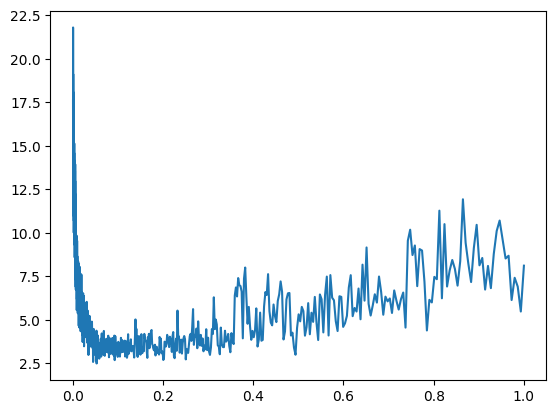

In [121]:
# From the above plot the best learning rate is between 0.1 - 0.2
plt.plot(lri, lossi)


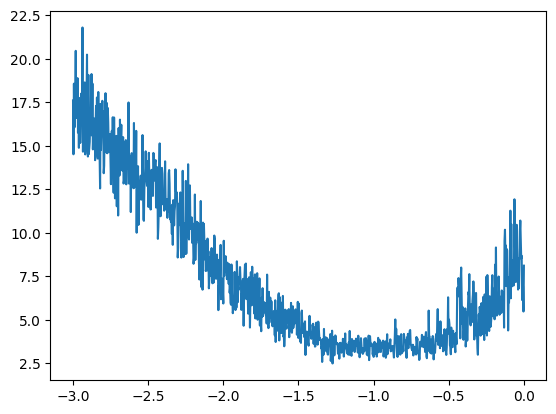

In [122]:
plt.plot(lrei, lossi)

In [125]:
g = torch.Generator().manual_seed(214748364)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

for i in range(10000):
    # construct minibatch of size 32.
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

2.510084390640259


In [126]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4247, grad_fn=<NllLossBackward0>)

In [127]:
# split into training, validation and test dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one.
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(43)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182460, 3]) torch.Size([182460])
torch.Size([22811, 3]) torch.Size([22811])
torch.Size([22875, 3]) torch.Size([22875])


In [128]:
g = torch.Generator().manual_seed(214748364)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

X = Xtr
Y = Ytr
for p in parameters:
    p.requires_grad = True

for i in range(30000):
    # construct minibatch of size 32.
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

2.5915658473968506


In [130]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4207, grad_fn=<NllLossBackward0>)

In [131]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4522, grad_fn=<NllLossBackward0>)

In [133]:
# when the training loss and validation sample loss are close, it means the model is underfitting.
# 
g = torch.Generator().manual_seed(214748364)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print("parameters:", sum(p.nelement() for p in parameters))

X = Xtr
Y = Ytr
for p in parameters:
    p.requires_grad = True

for i in range(30000):
    # construct minibatch of size 32.
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

parameters: 10281
2.810945987701416


In [134]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4977, grad_fn=<NllLossBackward0>)

In [135]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5287, grad_fn=<NllLossBackward0>)